### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.

In [1]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

####  Setup the Environment to generate synthetic stock price data


In [55]:
# create a synthatic stock price dataset
np.random.seed(42)
data_length = 2000 
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthatic_data = trend + noise

# Create dataframe and save it as stock_prices.csv
data = pd.DataFrame(synthatic_data, columns = ["close"])
data.to_csv("stock_prices.csv", index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [56]:
# Load the dataset
data = pd.read_csv("stock_prices.csv")
data = data[["close"]].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# prepare the data for training
def create_dataset(data, time_step = 1):
    x, y = [],[]

    for i in range(len(data)-time_step-1):
        a = data[i:(i + time_step), 0]
        x.append(a)
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

time_step = 100
x, y = create_dataset(data, time_step)
x = x.reshape(x.shape[0], x.shape[1], 1)

print("Shape of X:", x.shape) 
print("Shape of Y:", y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [57]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # convert to another type use cast
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    # split heads method splits the inputs into multiple heads for parallel attention computation
    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # the call method applies the setf attention mechanism and combine the heads
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # split heads func
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # attention func
        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        output = self.combine_heads(concat_attention)
        return output
    
        

In the above code: 

- The `MultiHeadSelfAttention` layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The `attention parameter` computes the attention scores and weighted sum of the values. 

- The `split_heads` parameter splits the input into multiple heads for parallel attention computation. 

- The `call method` applies the self-attention mechanism and combines the heads. 


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [58]:
class  TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)

        # Implement feed forward network layers
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation = "relu"),
            Dense(embed_dim)
        ])

        # Normalizatoin layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout layers
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs +attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

In the above code:

- The `TransformerBlock layer` combines `multi-head self-attention` with a `feed-forward neural networ`k and `normalization layers`.  

- `Dropout` is used to prevent overfitting. 

- The `call` method applies the `self-attention`, followed by the `feedforward network` with `residual connection`s and `layer normalization`.


### Step 4: Implement Encoder Layer 

Define the Encoder layer. 


In [59]:
class EncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(EncoderLayer, self).__init__()
        
        # Self attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        # feed forward network layer
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation ="relu"),
            Dense(embed_dim),
        ])

        # Normalization layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

    def call(self, inputs, training):
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        
        out1 = self.layernorm1(inputs + attn_output) # out1->input + attn_output
        
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training)  
        return self.layernorm2(out1 + ffn_output) # out1 + ffn_output

In the above code: 

- The `EncoderLayer` is similar to the `TransformerBlock` but is a reusable layer in the Transformer architecture. 

- It consists of a `MultiHeadSelfAttention mechanism` followed by a `feedforward neural network`. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The `call` method applies the self-attention, followed by the `feedforward network`, with `residual connections` and `layer normalization`. 


### Step 5: Implement Transformer encoder 

Define the Transformer Encoder. 


In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # convert to another type use cast
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    # split heads method splits the inputs into multiple heads for parallel attention computation
    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # the call method applies the setf attention mechanism and combine the heads
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # split heads func
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # attention func
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        output = self.combine_heads(concat_attention)
        return output
    
class  TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)

        # Implement feed forward network layers
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation = "relu"),
            Dense(embed_dim)
        ])

        # Normalizatoin layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout layers
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs +attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training) 
        return x

# sample usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False) # Use keyword argument for 'training' 
print(outputs.shape)

(1, 100, 128)


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [61]:
# Define necessary parameters

embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# define transformer encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (x.shape[1], x.shape[2])
inputs = tf.keras.Input(shape = input_shape)

# project the inputs to the embed_dim
x1 = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x1)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)

# Create model
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(optimizer = "adam",
              loss = "mse"
             )

# summary of the model
model.summary()

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)          │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_496 (Dense)                    │ (None, 100, 128)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_19               │ (None, 100, 128)            │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_497 (Dense)                    │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [62]:
# train the model
model.fit(x,y, epochs =20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - loss: 11.5212
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.2693
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.1849
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.1731
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.1448
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 0.1388
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.1402
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.1218
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.2906
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0921
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.0818
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 0.1354
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0768
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.1039
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 

### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


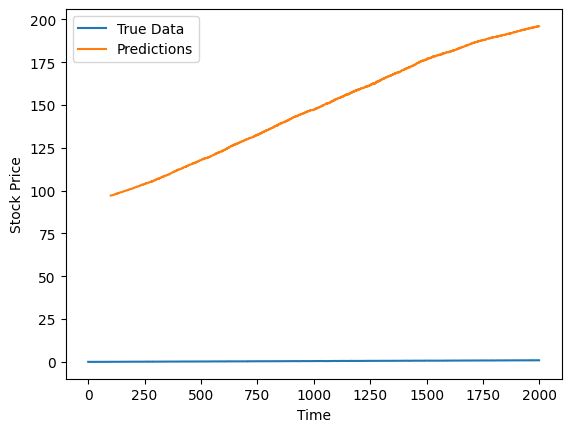

In [63]:
# Make predictions
predictions = model.predict(x)
predictions = scaler.inverse_transform(predictions)

# plot the predictions
import matplotlib.pyplot as plt

plt.plot(data, label="True Data")
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 